# Essentials Notebook
This notebook provides most important and must have tools for early stage analysis.
It allows to quickly verify reward function and identify potential problems.

Analysis is divided into 3 sections:
- Vehicle Behaviour
- Reward Properties
- Track Analysis

There are few code explanations, because it is assumed, that you have already visited *Training_analysis* notebook and have some knowledge about parameters described here. Non standard implementations are documented.

## Import modules

In [220]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from deepracer.tracks import TrackIO, Track
from deepracer.logs import CloudWatchLogs as cw, \
    SimulationLogsIO as slio, \
    AnalysisUtils as au, \
    PlottingUtils as pu

## Load track

In [2]:
!ls tracks/

AmericasGeneratedInclStart.npy	New_York_Eval_Track.npy
AWS_track.npy			New_York_Track.npy
Bowtie_track.npy		Oval_track.npy
Canada_Eval.npy			reInvent2019_track.npy
Canada_Training.npy		reInvent2019_wide_mirrored.npy
China_eval_track.npy		reInvent2019_wide.npy
China_track.npy			reinvent_base.npy
H_track.npy			Spain_track.npy
LGSWide.npy			Straight_track.npy
London_Loop_Train.npy		Tokyo_Training_track.npy
Mexico_track_eval.npy		Vegas_track.npy
Mexico_track.npy		Virtual_May19_Train_track.npy


In [3]:
tu = TrackIO()

In [4]:
track = tu.load_track("Spain_track")

Loaded 259 waypoints


## Load log

In [5]:
stream_name = 'sim-kr7tzbgbhbjb' ## CHANGE This to your simulation application ID
fname = 'logs/deepracer-%s.log' %stream_name  # The log will be downloaded into the specified path

In [6]:
cw.download_log(fname, stream_prefix=stream_name)  # add force=True if you downloaded the file before but want to repeat

Log file exists, use force=True to download again


In [7]:
EPISODES_PER_ITERATION = 30 #  Set to value of your hyperparameter in training

data = slio.load_data(fname)
df = slio.convert_to_pandas(data, episodes_per_iteration=EPISODES_PER_ITERATION)

df = df.sort_values(['episode', 'steps'])

In [8]:
df

,iteration,episode,steps,x,y,yaw,steer,throttle,action,reward,done,on_track,progress,closest_waypoint,track_len,timestamp
0,1,0,3,0.1951,-2.1735,-179.8014,-8.0,1.7,2.0,1.0005,0,True,0.2544,0,60.0,1590657948.3697615
1,1,0,4,0.1555,-2.1752,-179.2648,-8.0,1.7,2.0,1.0157,0,True,0.3204,1,60.0,1590657948.4296672
2,1,0,5,0.1069,-2.1769,-178.8786,16.0,1.6,5.0,1.0236,0,True,0.4015,1,60.0,1590657948.490023
3,1,0,6,0.0624,-2.1786,-178.6066,-8.0,1.7,2.0,1.0197,0,True,0.4755,1,60.0,1590657948.5606992
4,1,0,7,-0.0118,-2.1818,-178.1514,-8.0,1.7,2.0,1.0551,0,True,0.5993,1,60.0,1590657948.627823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63805,22,638,32,2.9794,-2.3366,-177.8503,-16.0,1.6,1.0,1.3032,0,True,5.6138,250,60.0,1590665178.8214679
63806,22,638,33,2.8490,-2.3294,178.7475,16.0,1.6,5.0,1.1698,0,True,5.8310,250,60.0,1590665178.8729532
63807,22,638,34,2.7579,-2.3210,176.8019,16.0,1.6,5.0,1.0831,0,True,5.9829,250,60.0,1590665178.9326193
63808,22,638,35,2.6560,-2.3120,175.8583,16.0,1.6,5.0,1.1038,0,True,6.1527,251,60.0,1590665178.9949973


# Vehicle Behaviour
## Action distribution
More even the distribution is the better the action space is matched with the track. Also can detect not used actions.

In [9]:
df['action'].value_counts().sort_index()

0.0    13532
1.0    12643
2.0    10290
3.0     4433
4.0     4456
5.0     9908
6.0     8548
Name: action, dtype: int64

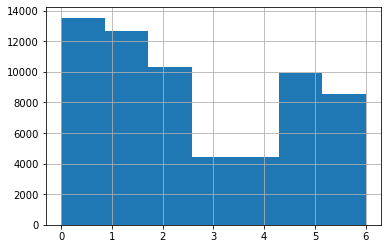

In [10]:
df['action'].hist(bins=int(df['action'].max() + 1))

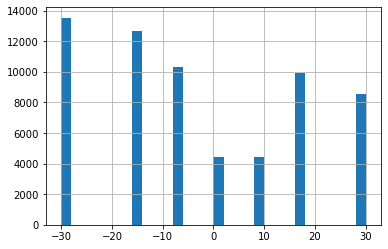

In [11]:
df['steer'].hist(bins=30)

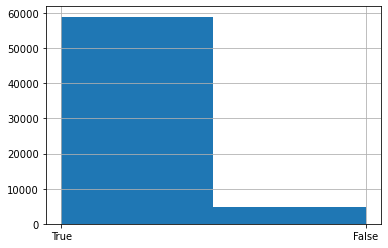

In [12]:
df['on_track'].hist(bins=2)

In [13]:
# once cmap support for pu.plot_track is added, plot steering around the track
#pu.plot_track(df, track, value_field='steer', margin=1, cmap='bwr')

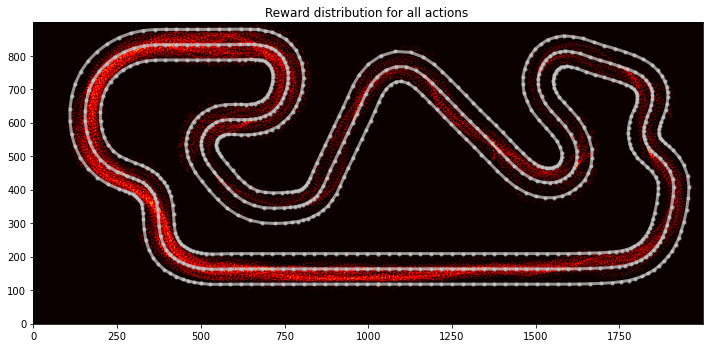

<Figure size 432x288 with 0 Axes>

In [14]:
pu.plot_track(df, track, value_field='throttle', margin=1)

## Progress per steps
The higher the value the better.

In [15]:
df['pps'] = df['progress'].values / (1 + df['steps'].values)

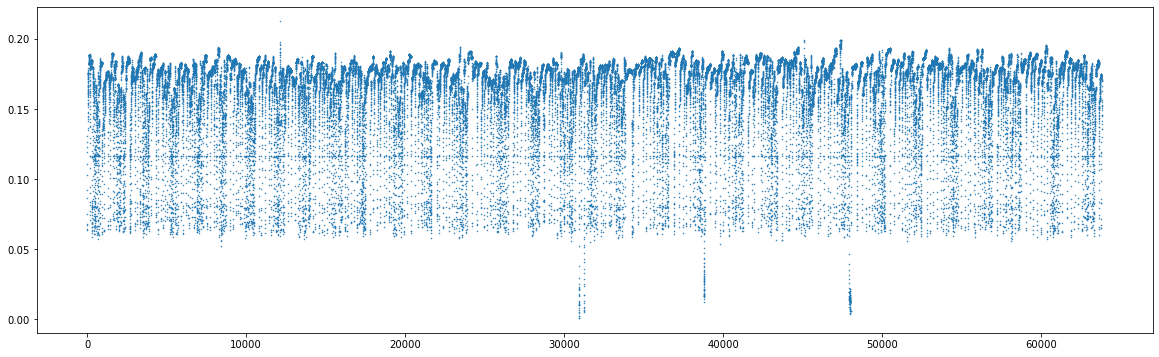

In [16]:
plt.figure(figsize=(20,6))
plt.plot(np.arange(0,len(df)), df['pps'], '.', markersize=1)

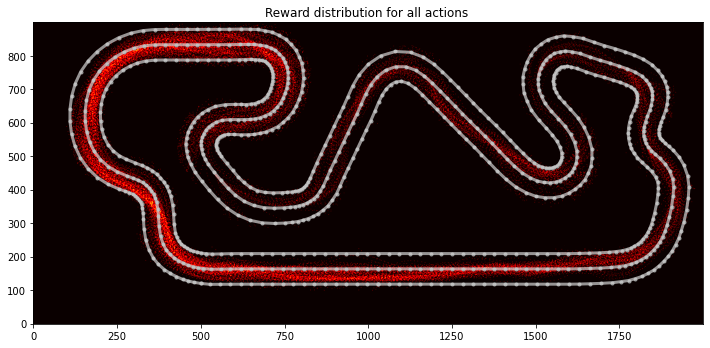

<Figure size 432x288 with 0 Axes>

In [17]:
pu.plot_track(df, track, value_field='pps', margin=1)

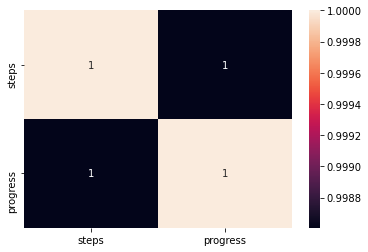

In [18]:
sns.heatmap(df[['steps', 'progress']].corr(), annot=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f06e6d17d60>,
      dtype=object)

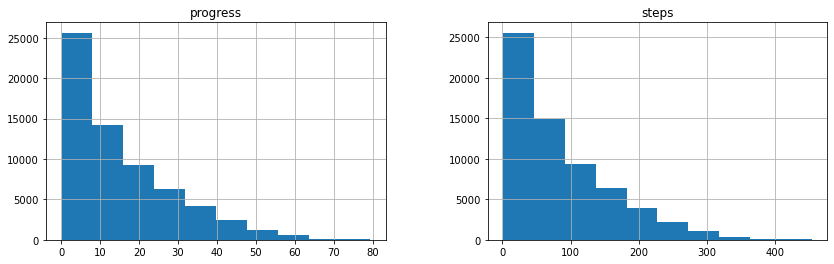

In [19]:
df[['steps', 'progress']].hist(figsize=(14,4))

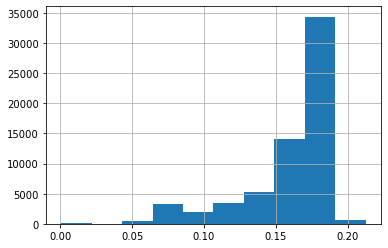

In [20]:
df['pps'].hist()

## Progress and progression tempo
Tempo is the track distance covered in a single step.

> **NOTE** that it is calculated from progress so zig-zag does not count. We care about distance covered towards the finish line.

The higher the value the better progress car is making.

In [21]:
def tempo(progress):
    result = np.zeros(len(progress))
    last = 0.0
    for x in range(0,len(progress)):
        d = 0.0
        p = progress[x] / 100.0
        if last < p:
            d = p - last
        result[x] = d
        last = max(float(p), 0.0)
    return result

In [22]:
# Logarithmic progress for increased contrast (subject to change if a better method of contrast increase is developed)
df['log_progress'] = [math.log(1.0 + r['progress'] / 10.0) for _,r in df.iterrows()]

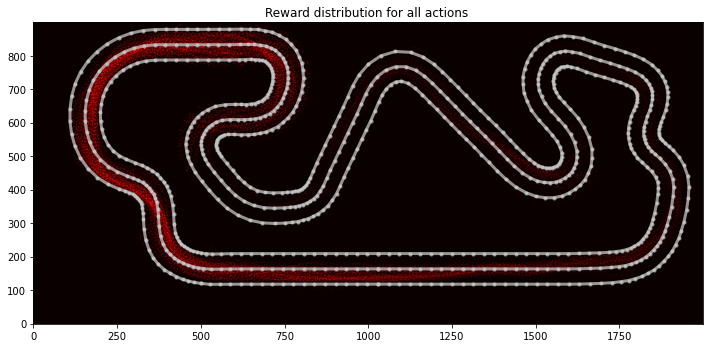

<Figure size 432x288 with 0 Axes>

In [23]:
pu.plot_track(df, track, value_field='log_progress', margin=1)

In [24]:
df['tempo'] = tempo(df['progress']) * df['track_len'][0]

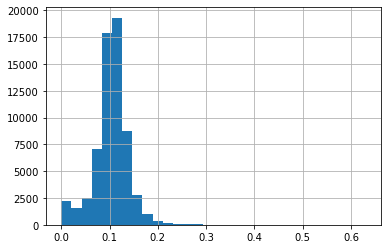

In [25]:
df['tempo'].hist(bins=30)

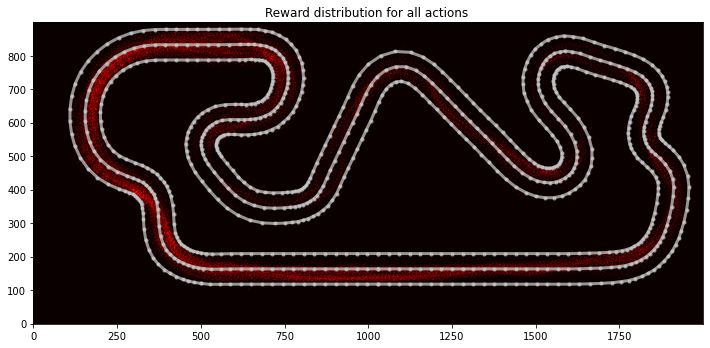

<Figure size 432x288 with 0 Axes>

In [26]:
pu.plot_track(df[df['tempo'] < 0.25], track, value_field='tempo')

# Reward Properties
Analyze returned reward, apply different rewards for comparison.

## Helper definitions

In [27]:
def plot_track(t, fig=None):
    ratio = (lambda x,y: x / y)(*t.size())
    if fig is None:
        fig = plt.figure(figsize=(16,8))
    ax = fig.add_subplot()
    ax.axis('equal')
    ax.plot(*t.center_line.T, 'b')
    ax.plot(*t.outer_border.T, 'b')
    ax.plot(*t.inner_border.T, 'b')
    return ax

In [28]:
def df2params(frame, track: Track, mapping=None):
    if mapping is None:
        mapping = {'on_track':'all_wheels_on_track', 'throttle':'speed',
                   'yaw':'heading', 'steer':'steering', 'track_len':'track_length', 'progress':'progress', 'steps':'steps',
                  'x':'x', 'y':'y', 'distance_from_center':'distance_from_center'}
    d = {'closest_waypoints': [frame['closest_waypoint'], (frame['closest_waypoint']+1)%len(track.center_line)]}
    width = np.linalg.norm(track.inner_border[0] - track.outer_border[0])
    d.update({'is_reversed':False, 'waypoints':track.center_line, 'track_width':width})
    d.update({mapping[k]:frame[k] for k in mapping})
    return d

In [29]:
import importlib

### Estimate missing parameters

In [30]:
def dist_from_center(row, waypoints):
    "Adds missing distance_from_center column"
    close = row['closest_waypoint']
    estimated = np.array(waypoints[close])
    pos = np.array([row['x'], row['y']])
    dist = np.linalg.norm(pos - estimated)
    return dist

In [31]:
df['distance_from_center'] = [dist_from_center(r, track.center_line) for _,r in df.iterrows()]

## Apply different reward

In [69]:
name = 'kvyat'
reward = importlib.import_module('rewards.{0}'.format(name))
# Reload module so it is always up to date
importlib.reload(reward)
reward_function = reward.reward_function

In [70]:
original = 'reward'
# Recalculate log can be unncessary because we use original value from memory
if 'log_'+original not in df.columns:
    df['log_' + original] = [math.log(1 + r[original]) for _,r in df.iterrows()]

In [71]:
df[name] = [reward_function(df2params(r, track)) for _,r in df.iterrows()]
df['log_' + name] = [math.log(1 + r[name]) for _,r in df.iterrows()]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f06e70ccd30>,
      dtype=object)

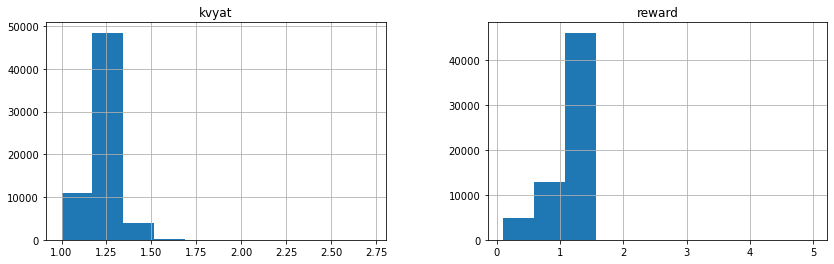

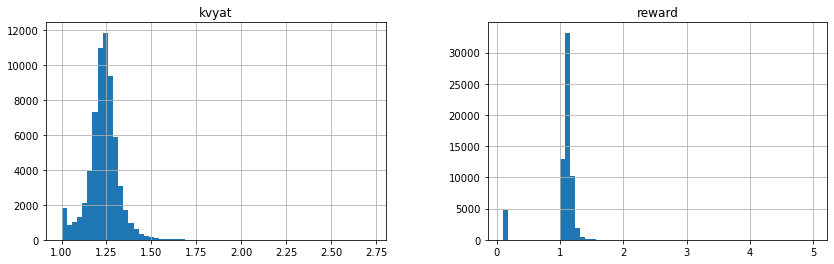

In [72]:
df[[original, name]].hist(figsize=(14,4))
df[[original, name]].hist(figsize=(14,4), bins=60)

In [73]:
sample = df.sample(frac=0.75)

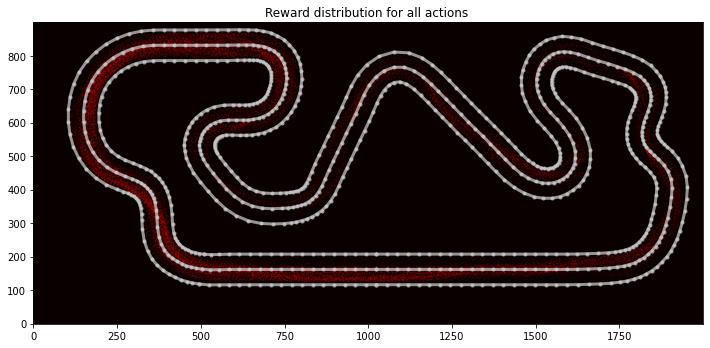

<Figure size 432x288 with 0 Axes>

In [74]:
pu.plot_track(sample, track, value_field='log_{0}'.format(original))

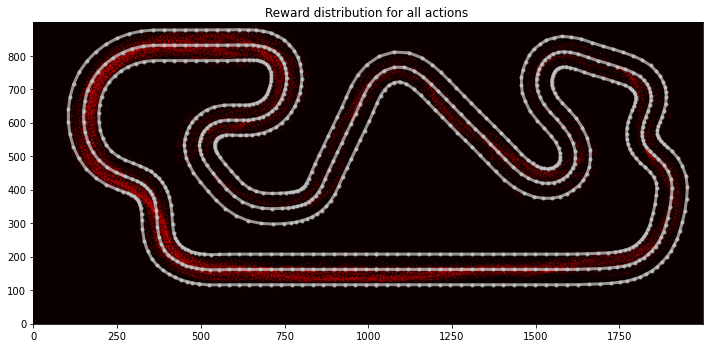

<Figure size 432x288 with 0 Axes>

In [75]:
pu.plot_track(sample, track, value_field='log_{0}'.format(name))

Text(0.5, 1.0, 'kvyat')

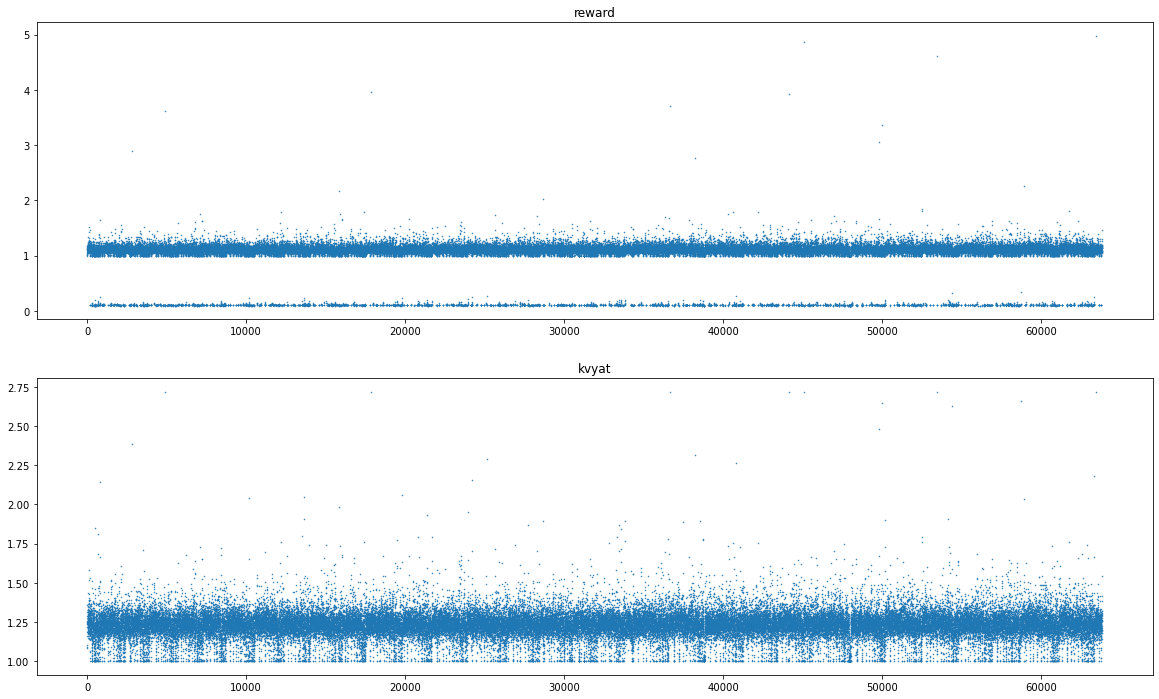

In [76]:
plt.figure(figsize=(20,12))

plt.subplot(2,1,1)
plt.plot(df.index, df[original], '.', markersize=1)
plt.title(original)

plt.subplot(2,1,2)
plt.plot(df.index, df[name], '.', markersize=1)
plt.title(name)

# Track Analysis
Explore track to find optimal path, calculate minimal steering and ideal racing line.

## Sector builder
Let's define sectors around the track. Mapping closest waypoint coordinates as a sector mark works well and can be used to construct interesting reward that stimulates improving every part of the track evenly.

In [44]:
DENSITY = 2.0
key = lambda wpt: [int(round(c * DENSITY)) / DENSITY for c in wpt]
keys = np.array([key(w) for w in track.center_line])

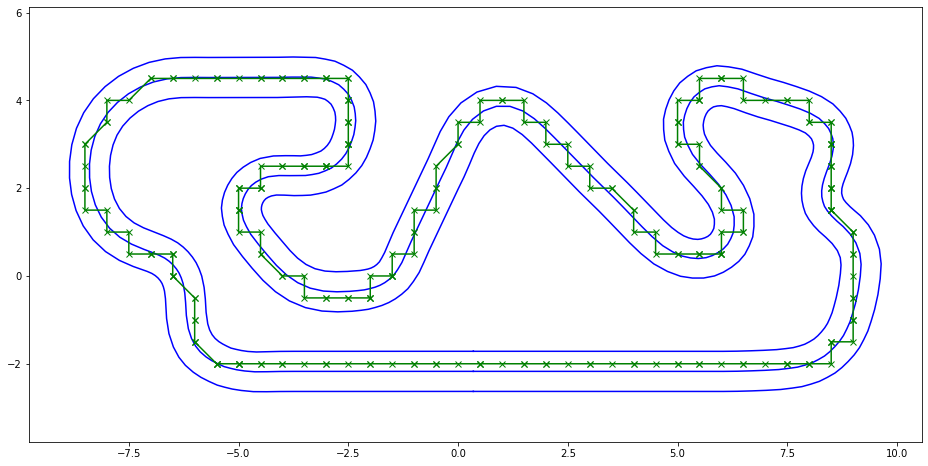

In [45]:
ax = plot_track(track)
ax.plot(*keys.T, 'gx-')

## Plot saved sectors
If your last computed reward function implements sectors global variable storing model records, you can plot it here.

In [46]:
sectors = pd.DataFrame([(a[0],a[1],b) for a,b in reward.sectors.items()], columns=['x', 'y', 'var'])
plt.plot(sectors.index, sectors['var'])

AttributeError: module 'rewards.kvyat' has no attribute 'sectors'

### Plot params per sector

In [47]:
df.columns

Index(['iteration', 'episode', 'steps', 'x', 'y', 'yaw', 'steer', 'throttle',
       'action', 'reward', 'done', 'on_track', 'progress', 'closest_waypoint',
       'track_len', 'timestamp', 'pps', 'log_progress', 'tempo',
       'distance_from_center', 'log_reward', 'kvyat', 'log_kvyat'],
      dtype='object')

## Track characteristics
Calculate perfect racing line, estimate best steering angles for the action space.

### Helpers

In [48]:
def track_distance(waypoints, i, N=1):
    next_waypoint = (i + N) % len(waypoints)
    A = np.array(waypoints[i])
    B = np.array(waypoints[next_waypoint])
    return np.linalg.norm(B - A) / N

In [49]:
def track_heading(waypoints, i, N=1, above=None, below=None):
    """
    Calculate track waypoints heading in radians.
    i : waypoint id
    N : waypoint look ahead
    above : indicies to tweak, values should be above PI
    below : indicies to tweak, values should be below PI
    """
    next_waypoint = (i + N) % len(waypoints)
    A = waypoints[i]
    B = waypoints[next_waypoint]
    t_heading = math.atan2(B[1] - A[1], B[0] - A[0])
    if above is not None and i in above and t_heading < 0:
        t_heading += math.pi*2
    if below is not None and i in below and t_heading > 0:
        t_heading -= math.pi*2
    return t_heading

In [104]:
def heading2track(heading, norms, w0, constant=None):
    """
    heading : polar coords angle
    norms : polar coords radius
    w0 : initial position
    """
    wpts = [np.array(w0)]
    for h,n in zip(heading, norms):
        polar = n * np.exp(1j * h)
        polar = np.array([np.real(polar), np.imag(polar)])
        if constant is not None:
            polar += constant * n
        wpts.append(np.array(wpts[-1]) + polar)
    return np.array(wpts[1:])

In [51]:
def int_heading(dheading, h0, dt, constant=0.0):
    ih = np.zeros(heading.shape)
    ih[0] = h0
    for i in range(0,len(dheading)):
        ih[i+1] = ih[i] + dheading[i] + constant * dt[i]
    return ih

### Analyze
Find best racing line. Credits to https://medium.com/myplanet-musings/the-best-path-a-deepracer-can-learn-2a468a3f6d64

#### Tune parameters above and below
Tune parameters so that the heading plot is continuous. Problem occurs at heading 180 deg, because it jumps to -180 deg, making it a non-differentiable step function.

In [52]:
above = list(range(0,25))
below = list(range(225,270)) + list(range(90,98))

In [53]:
ix = np.arange(len(track.center_line))
dt = np.array([track_distance(track.center_line, i, N=2) for i in ix])
t = np.cumsum(dt)
heading = np.array([track_heading(track.center_line, i, N=2, above=above, below=below) for i in ix])
d_heading = heading[1:] - heading[:-1]

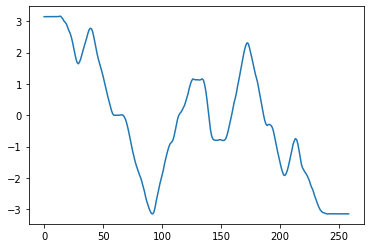

In [54]:
plt.plot(ix, heading)

#### Distance and distance derivative

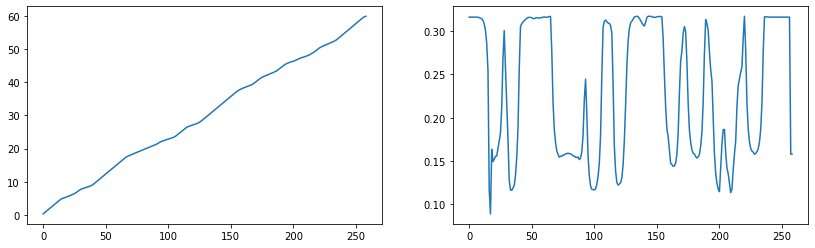

In [55]:
plt.figure(figsize=(14,4))
plt.subplot(121)
plt.plot(ix, t)
plt.subplot(122)
plt.plot(ix, dt)

#### After tuning
Plot heading over distance.

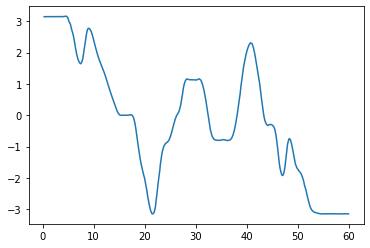

In [56]:
plt.plot(t, heading)

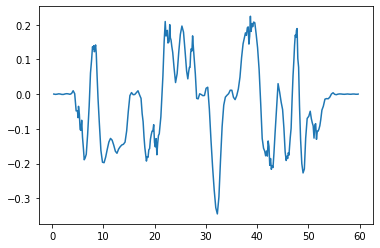

In [57]:
plt.plot(t[:-1], d_heading)

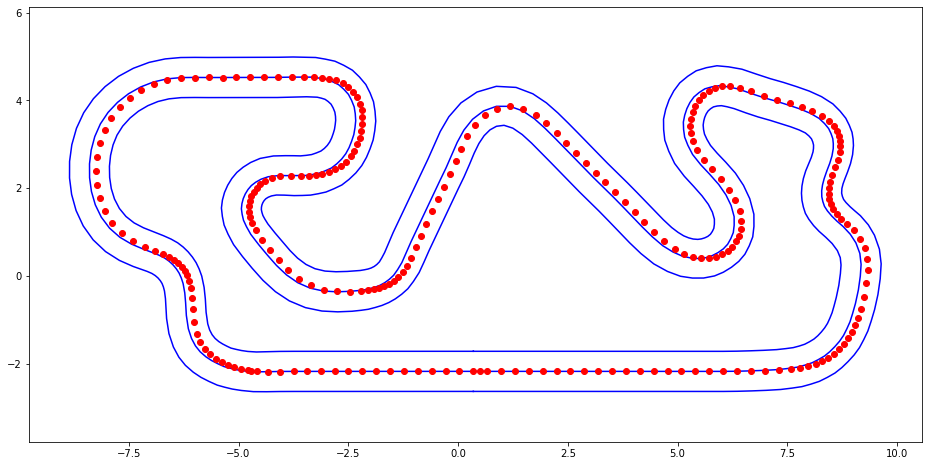

In [60]:
from_heading = heading2track(heading, dt, track.center_line[0])
ax = plot_track(track)
ax.plot(*from_heading.T, 'ro')

### Apply low-pass filter

In [105]:
def low_pass_filter(data, rc=1.0):
    xin = data[1]
    dt = data[0]
    alpha = dt / (rc + dt)
    yout = np.zeros(xin.shape)
    yout[0] = xin[0]
    for i in range(1,len(yout)):
        yout[i] = alpha[i] * xin[i] + (1.0 - alpha[i]) * yout[i-1]
    return yout

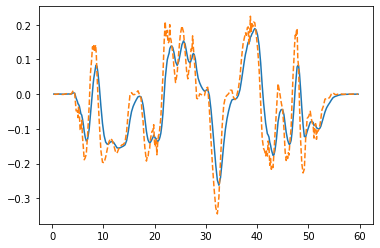

In [159]:
dh = low_pass_filter([dt, d_heading], 0.7)
plt.plot(t[:-1], dh)
plt.plot(t[:-1], d_heading, '--')

In [169]:
hconst = 0.0
pconst = 0.0

In [173]:
i_heading = int_heading(dh, heading[0], dt, hconst)

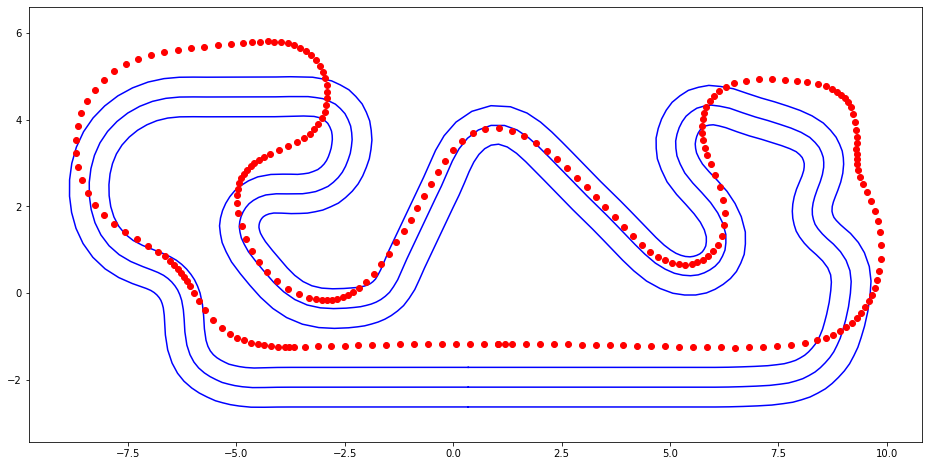

In [182]:
start = track.center_line[0] + np.array([1.0,1.0])
from_heading = heading2track(i_heading, dt, start, pconst)
ax = plot_track(track)
ax.plot(*from_heading.T, 'ro')

In [172]:
err = i_heading[0] - i_heading[-1]
err = min(err, err - 2*math.pi)
hconst = err / t[-1]

In [175]:
pconst = (from_heading[0] - from_heading[-1]) / t[-1]

## Choosing steering angles
Let's find most proper steering angles.

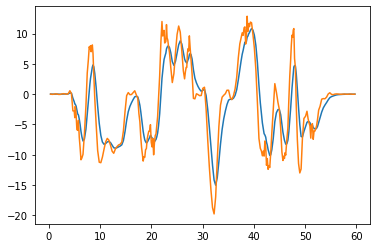

In [218]:
steering = np.array([t[:-1], np.degrees(dh)])
plt.plot(*steering)
plt.plot(t[:-1], np.degrees(d_heading))

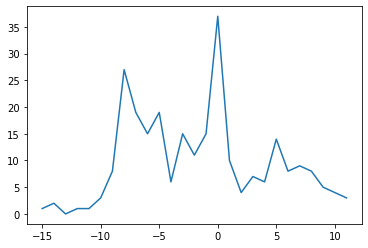

In [219]:
limit = np.arange(round(steering[1].min()), round(steering[1].max())+1)
pivot = np.array([len(steering.T[steering[1].round() == ang]) for ang in limit])
plt.plot(limit, pivot)

# Bonus : Visualize reward

## Compare functions
Choose your warrior wisely. See which distribution does suit your needs best.

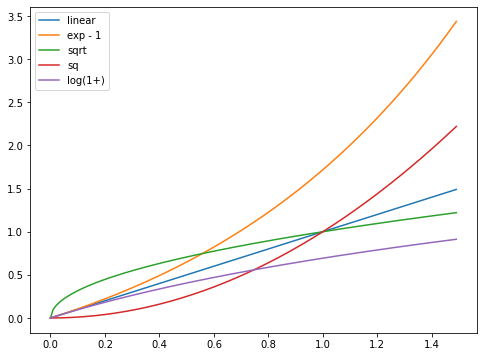

In [195]:
ox = np.arange(0,1.5,0.01)
plt.figure(figsize=(8,6))
plt.plot(ox, ox)
plt.plot(ox, np.exp(ox) - 1)
plt.plot(ox, np.sqrt(ox))
plt.plot(ox, np.power(ox, 2.0))
plt.plot(ox, np.log(1 + ox))
plt.legend(['linear','exp - 1','sqrt','sq','log(1+)'])

## Plot 3d reward distribution

To create a 3d plot we use a sample from our logs and update 2 of its parameters creating a 2d space of inputs. Once that is done we simply iterate over these plane calculating the reward for such parameters combination.

> Z coordinate is the reward result. `jupyter notebook` classical notebook is needed to create interactive plots.

In [ ]:
# Works only with jupyter notebook
%matplotlib notebook

In [454]:
def plot3d_reward(fig, x, y, rewardf):
    "Plot rewardf(x,y) reward to visualize reward resoponse on x,y parameters change"
    X,Y = np.meshgrid(x, y)
    Z = np.zeros(X.shape)
    # ideally array should be passed into the reward, but some rewards use functions from math library, which is incompatible with numpy arrays
    # to solve this problem we calculate reward iteratively
    for r in range(0,Z.shape[0]):
        for c in range(0,Z.shape[1]):
            Z[r,c] = rewardf(X[r,c], Y[r,c])
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X,Y,Z)
    return ax

In [455]:
def updated_params(params, **kwargs):
    p = dict(params)
    p.update(kwargs)
    return p

In [458]:
src = df.sample(n=1)
src

,iteration,episode,steps,x,y,yaw,steer,throttle,action,reward,...,timestamp,pps,log_progress,tempo,distance_from_center,log_reward,hamilton,log_hamilton,adversarial,log_adversarial
21676,9,254,49,8.6099,2.2885,-71.6803,-30.0,1.5,0.0,1.0513,...,1590660391.2660327,0.173518,0.624649,0.07164,0.232651,0.718474,2.331869,1.203534,1.205217,0.790826


In [459]:
params = df2params(src.iloc[0], track)
rew = lambda x, y: reward_function(updated_params(params, distance_from_center=x, heading=y))

In [460]:
X = np.arange(0.0, params['track_width'], 0.01)
Y = np.arange(-180, 180, 0.1)

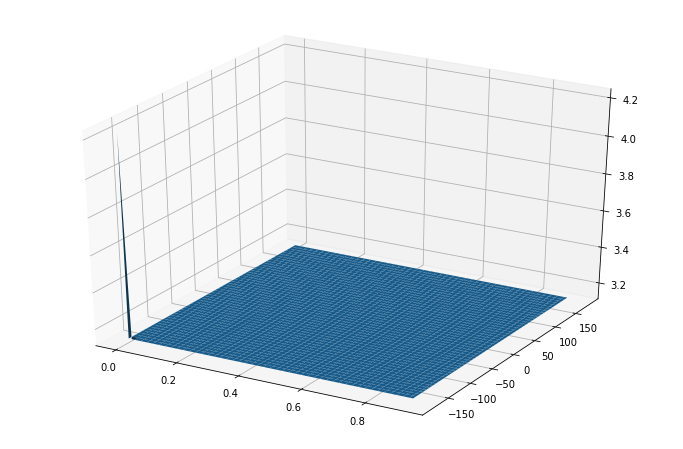

In [461]:
fig = plt.figure(figsize=(12,8))
plot3d_reward(fig, X, Y, rew)